In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from scipy import integrate
from scipy.optimize import brentq, fsolve, minimize_scalar
from scipy.stats import norm, multivariate_normal

In [2]:
# Parameters (WTI Sep '23 (CLU23) on July 07 2023 10:44am CDT)
futures_price = 72.89
strike_price = 72.5
# risk_free_rate = 0.0535
risk_free_rate = 0.0
time_to_maturity = 41/365
vol_black = 0.33
vol_bachelier = vol_black*futures_price

## Bachelier (1900)
$$dF_t = \sigma dW_t$$

In [3]:
# Bachelier (1900)
class Bachelier:
    def __init__(self, F, vol, r, tau):
      self.F = F
      self.vol = vol
      self.r = r
      self.tau = tau


    def option_pricer(self, vol = None, K = None, option_type = 'call'):
      '''
      Bachelier formula
      return call/put option price
      '''
      # default parameter
      if vol == None:
        vol = self.vol

      m = (self.F - K) / (vol * np.sqrt(self.tau))
      if option_type == 'call':
        return np.exp(-self.r * self.tau) * ((self.F - K)*norm.cdf(m) + vol * self.tau**0.5 * norm.pdf(m))
      elif option_type == 'put':
        return np.exp(-self.r * self.tau) * ((K - self.F)*(1-norm.cdf(m)) + vol * self.tau**0.5 * norm.pdf(m))


    def simulate_F(self, paths = 100000, steps = None):
      '''
      Monte Carlo simulation
      return underlying futures price and time vector
      '''
      # default parameter
      if steps == None:
        steps = 2

      # initialize vectors
      arr_F = np.zeros((paths, steps))
      arr_F[:,0] = self.F

      # generate Brownian motion
      arr_w = np.random.standard_normal(size = (paths, steps-1))

      # compute the corresponding price
      T_vec, dt = np.linspace(0, self.tau, steps, retstep=True)
      for t in range(0, steps-1):
        arr_F[:,t+1] = arr_F[:,t] + self.vol * dt**0.5 * arr_w[:,t]

      return arr_F, T_vec

In [4]:
bachelier = Bachelier(futures_price, vol_bachelier, risk_free_rate, time_to_maturity)
bachelier_call = bachelier.option_pricer(K = strike_price, option_type = 'call')
bachelier_put = bachelier.option_pricer(K = strike_price, option_type = 'put')

print(f'Bachelier formula: call is {bachelier_call:.4f}')
print(f'Bachelier formula: put is {bachelier_put:.4f}')

Bachelier formula: call is 3.4149
Bachelier formula: put is 3.0249


In [5]:
# verify through Monte Carlo simulation
paths = 1000000
arr_F, _ = bachelier.simulate_F(paths = paths)

arr_V = np.exp(-risk_free_rate*time_to_maturity) * np.maximum(arr_F[:,-1] - strike_price, 0)
mean_call, ste_call = arr_V.mean(), arr_V.std() / paths**0.5
arr_V = np.exp(-risk_free_rate*time_to_maturity) * np.maximum(strike_price - arr_F[:,-1], 0)
mean_put, ste_put = arr_V.mean(), arr_V.std() / paths**0.5

print(f'Monte Carlo simulation: call is {mean_call:.4f} with standard error {ste_call:.6f}')
print(f'Monte Carlo simulation: put is {mean_put:.4f} with standard error {ste_put:.6f}')

Monte Carlo simulation: call is 3.4112 with standard error 0.004843
Monte Carlo simulation: put is 3.0281 with standard error 0.004574


## Black (1976)
$$dF_t = \sigma F_tdW_t$$

In [6]:
# Black (1976)
class Black:
    def __init__(self, F, vol, r, tau):
      self.F = F
      self.vol = vol
      self.r = r
      self.tau = tau


    def option_pricer(self, vol = None, K = None, option_type = 'call'):
      '''
      Black formula
      return call/put option price
      '''
      # default parameter
      if vol == None:
        vol = self.vol

      d1 = (np.log(self.F / K) +  0.5 * vol ** 2 * self.tau) / (vol * np.sqrt(self.tau))
      d2 = (np.log(self.F / K) -  0.5 * vol ** 2 * self.tau) / (vol * np.sqrt(self.tau))
      if option_type == 'call':
        return np.exp(-self.r * self.tau) * ( self.F * norm.cdf(d1) - K * norm.cdf(d2))
      elif option_type == 'put':
        return np.exp(-self.r * self.tau) * ( K * (1 - norm.cdf(d2)) - self.F * (1 - norm.cdf(d1)))


    def simulate_F(self, paths = 100000, steps = None):
      '''
      Monte Carlo simulation
      return underlying futures price and time vector
      '''
      # default parameter
      if steps == None:
        steps = 2

      # initialize vectors
      arr_F = np.zeros((paths, steps))
      arr_F[:,0] = self.F

      # generate Brownian motion
      arr_w = np.random.standard_normal(size = (paths, steps-1))

      # compute the corresponding price
      T_vec, dt = np.linspace(0, self.tau, steps, retstep=True)
      for t in range(0, steps-1):
        arr_F[:,t+1] = arr_F[:,t] * np.exp( -0.5 * self.vol**2 * dt + self.vol * dt**0.5 * arr_w[:,t] )

      return arr_F, T_vec


In [7]:
black = Black(futures_price, vol_black, risk_free_rate, time_to_maturity)
black_call = black.option_pricer(K = strike_price, option_type = 'call')
black_put = black.option_pricer(K = strike_price, option_type = 'put')

print(f'Black formula: call is {black_call:.4f}')
print(f'Black formula: put is {black_put:.4f}')

Black formula: call is 3.4047
Black formula: put is 3.0147


In [8]:
# verify through Monte Carlo simulation
paths = 1000000
arr_F, _ = black.simulate_F(paths = paths)

arr_V = np.exp(-risk_free_rate*time_to_maturity) * np.maximum(arr_F[:,-1] - strike_price, 0)
mean_call, ste_call = arr_V.mean(), arr_V.std() / paths**0.5
arr_V = np.exp(-risk_free_rate*time_to_maturity) * np.maximum(strike_price - arr_F[:,-1], 0)
mean_put, ste_put = arr_V.mean(), arr_V.std() / paths**0.5

print(f'Monte Carlo simulation: call is {mean_call:.4f} with standard error {ste_call:.6f}')
print(f'Monte Carlo simulation: put is {mean_put:.4f} with standard error {ste_put:.6f}')

Monte Carlo simulation: call is 3.4084 with standard error 0.005156
Monte Carlo simulation: put is 3.0115 with standard error 0.004277


## Heston (1993)
\begin{cases}
dF_t = \sqrt{v_t} F_t dW^1_t \\
dv_t = \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dW^2_t\\
dW^1_tdW^2_t = \rho dt
\end{cases}

In [9]:
# Heston (1993)

def cf(u, tau, mu, rho, v0, theta, kappa, sigma):

    """
    Heston characteristic function in Schoutens (2004)
    """

    d = ((kappa - rho*sigma*u*1j)**2 + sigma**2*(1j*u + u**2))**0.5
    g = (kappa - rho*sigma*u*1j - d)/(kappa - rho*sigma*u*1j + d)
    cf_ = np.exp( 1j*u*mu*tau +\
                 theta*kappa*sigma**-2*((kappa - rho*sigma*u*1j - d)*tau - 2*np.log((1 - g*np.exp(-d*tau))/( 1 - g))) +\
                 v0*sigma**-2*(kappa - rho*sigma*u*1j - d)*(1 - np.exp(-d*tau))/(1 - g*np.exp(-d*tau)) )
    return cf_

class Heston:
    def __init__(self, F, rho, v0, theta, kappa, sigma,  r, tau):
      self.F = F
      self.rho = rho
      self.v0 = v0 # spot variance
      self.theta = theta
      self.kappa = kappa
      self.sigma = sigma
      self.r = r
      self.tau = tau
      if 2*kappa * theta < sigma**2:
        print(f'The parameters entered fail the Feller condition')


    def option_pricer(self, K = None, option_type = 'call'):
      '''
      Fourier inversion
      return call/put option price
      '''

      k = np.log(K/self.F)
      cf_ = partial(cf, tau = self.tau, mu = 0, rho = self.rho, v0 = self.v0, theta = self.theta, kappa = self.kappa, sigma = self.sigma )

      integrand_Q1 = lambda u: np.real((np.exp(-u*k*1j) * cf_(u-1j) / (u*1j)) / cf_(-1j))
      integrand_Q2 = lambda u: np.real(np.exp(-u*k*1j) * cf_(u) / (u*1j))

      Q1 = 1/2 + 1/np.pi * integrate.quad(integrand_Q1, 1e-15, np.inf, limit=2000)[0]
      Q2 = 1/2 + 1/np.pi * integrate.quad(integrand_Q2, 1e-15, np.inf, limit=2000)[0]

      if option_type == 'call':
        return np.exp(-self.r * self.tau) * ( self.F * Q1 - K * Q2)
      elif option_type == 'put':
        return np.exp(-self.r * self.tau) * ( K * (1-Q2) - self.F * (1-Q1) )


    def simulate_F(self, paths = 10000, steps = None):
      '''
      Monte Carlo simulation
      return underlying futures price and time vector
      '''

      # default parameter
      if steps == None:
        steps = int(self.tau*252*4)

      # Initialize vectors
      arr_F = np.zeros((paths,steps)); arr_F[:,0] = self.F
      arr_v = np.zeros((paths,steps)); arr_v[:,0] = self.v0

      # Generate random 2D Brownian motions
      arr_w = multivariate_normal.rvs( mean = np.array([0, 0]),
                                        cov = np.array([[1, self.rho], [self.rho, 1]]),
                                        size = (paths, steps-1) )

      # Compute the corresponding paths
      T_vec, dt = np.linspace(0, self.tau, steps, retstep=True)
      for t in range(0,steps-1):
        arr_F[:,t+1] = arr_F[:,t] + arr_F[:,t] * ( arr_v[:,t] * dt )**0.5 * arr_w[:,t,0]
        arr_v[:,t+1] = arr_v[:,t] + self.kappa * ( self.theta - arr_v[:,t] ) * dt + self.sigma * ( arr_v[:,t] * dt )**0.5 * arr_w[:,t,1]
        arr_v[arr_v[:,t+1] < 0.0, t+1] = 1e-5 # prevent negative variance

      return arr_F, T_vec


In [10]:
# Heston parameters
rho = -0.30                                         # correlation coefficient
v0 = 0.30**2                                        # spot variance
theta = 0.40**2                                     # long-term variance
kappa = 5.0                                         # mean reversion coefficient
sigma = 0.7                                         # volatility of instantaneous variance (Vol of Vol)

In [11]:
heston = Heston(futures_price, rho, v0, theta, kappa, sigma, risk_free_rate, time_to_maturity)
heston_call = heston.option_pricer(K = strike_price, option_type = 'call')
heston_put = heston.option_pricer(K = strike_price, option_type = 'put')

print(f'Heston (foruier inversion): call is {heston_call:.4f}')
print(f'Heston (foruier inversion): put is {heston_put:.4f}')

Heston (foruier inversion): call is 3.3257
Heston (foruier inversion): put is 2.9357


In [12]:
# verify through Monte Carlo simulation
paths = 10000
arr_F, _ = heston.simulate_F(paths = paths)

arr_V = np.exp(-risk_free_rate*time_to_maturity) * np.maximum(arr_F[:,-1] - strike_price, 0)
mean_call, ste_call = arr_V.mean(), arr_V.std() / paths**0.5
arr_V = np.exp(-risk_free_rate*time_to_maturity) * np.maximum(strike_price - arr_F[:,-1], 0)
mean_put, ste_put = arr_V.mean(), arr_V.std() / paths**0.5

print(f'Monte Carlo simulation: call is {mean_call:.4f} with standard error {ste_call:.6f}')
print(f'Monte Carlo simulation: put is {mean_put:.4f} with standard error {ste_put:.6f}')

Monte Carlo simulation: call is 3.3095 with standard error 0.048315
Monte Carlo simulation: put is 2.9659 with standard error 0.044921


## Quadratic Normal Model (2023)
\begin{cases}
dF_t = \sigma(F_t)dW_t \\
\sigma(F_t) = cF^2 + bF + a = c(F-\frac{-b}{2c})^2  + a - \frac{b^2}{4c}
\end{cases}

In [13]:
# Quadratic Normal Model (2023)
class QNM:
    def __init__(self, F, a, b, c, tau):
      self.F = F
      self.a = a
      self.b = b
      self.c = c
      self.tau = tau


    def option_pricer(self, K = None, option_type = 'call'):
      '''
      The method of linearization
      return call/put option price
      '''
      m = (self.F - K)/(self.a * self.tau**0.5)
      C_BC = (self.F - K)*norm.cdf(m) + self.a * np.sqrt(self.tau) * norm.pdf(m)
      U = self.tau**0.5 * norm.pdf((self.F-K)/self.tau**0.5) * (self.b*(self.F + K)/2 + self.c*(self.F**2 + self.F*K + K**2 + 0.5*self.a**2 * self.tau)/3)

      if option_type == 'call':
        return C_BC + U
      elif option_type == 'put':
        return C_BC + U + K - self.F


    def simulate_F(self, paths = 100000, steps = None):
      '''
      Monte Carlo simulation
      return underlying futures price and time vector
      '''
      # default parameter
      if steps == None:
        steps = 2

      # initialize vectors
      arr_F = np.zeros((paths, steps))
      arr_F[:,0] = self.F

      # generate Brownian motion
      arr_w = np.random.standard_normal(size = (paths, steps-1))

      # compute the corresponding price
      T_vec, dt = np.linspace(0, self.tau, steps, retstep=True)
      for t in range(0, steps-1):
        arr_F[:,t+1] = arr_F[:,t] + self.vol * dt**0.5 * arr_w[:,t]

      return arr_F, T_vec

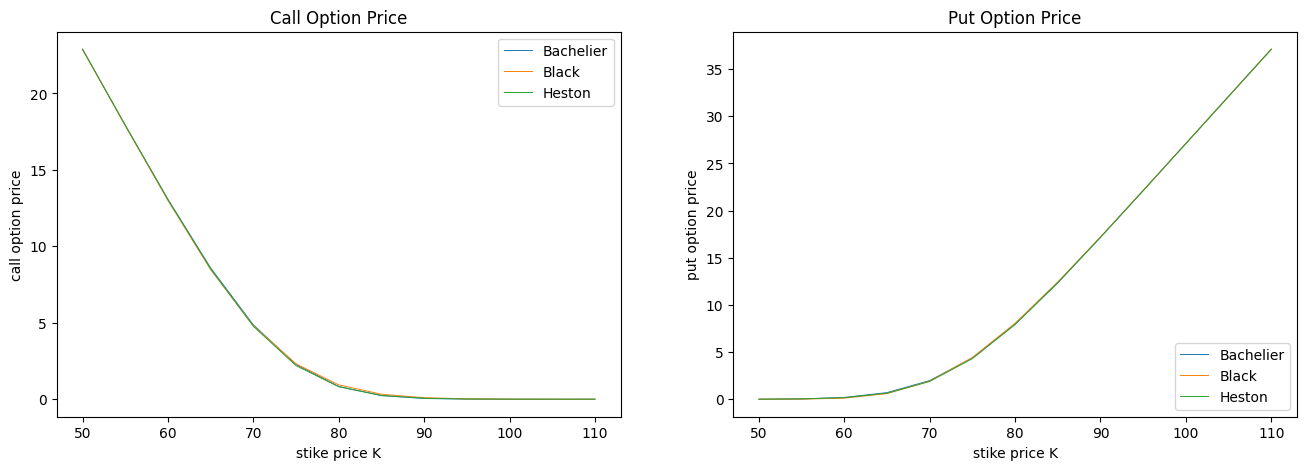

In [14]:
arr_strike = np.arange(50,111,5)

# call option
arr_bachelier_call = bachelier.option_pricer(K = arr_strike, option_type = 'call')
arr_black_call = black.option_pricer(K = arr_strike, option_type = 'call')
list_heston_call = []
for strike_ in arr_strike:
  list_heston_call.append(heston.option_pricer(K = strike_, option_type = 'call'))

# put option
arr_bachelier_put = bachelier.option_pricer(K = arr_strike, option_type = 'put')
arr_black_put = black.option_pricer(K = arr_strike, option_type = 'put')
list_heston_put = []
for strike_ in arr_strike:
  list_heston_put.append(heston.option_pricer(K = strike_, option_type = 'put'))

# create subplots
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(121)
ax1.plot(arr_strike, arr_bachelier_call, linewidth = 0.7, label = 'Bachelier')
ax1.plot(arr_strike, arr_black_call, linewidth = 0.7, label = 'Black')
ax1.plot(arr_strike, list_heston_call, linewidth = 0.7, label = 'Heston')
ax1.set_title('Call Option Price')
ax1.set_xlabel('stike price K')
ax1.set_ylabel('call option price')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(122)
ax2.plot(arr_strike, arr_bachelier_put, linewidth = 0.7, label = 'Bachelier')
ax2.plot(arr_strike, arr_black_put, linewidth = 0.7, label = 'Black')
ax2.plot(arr_strike, list_heston_put, linewidth = 0.7, label = 'Heston')
ax2.set_title('Put Option Price')
ax2.set_xlabel('stike price K')
ax2.set_ylabel('put option price')
ax2.legend(loc='lower right')

plt.show()

## Implied Volatility

In [15]:
def implied_volatility(option_price, F, K, r, tau, option_type = 'call', model = 'black', method='fsolve', disp=True):
    """
        Return Implied volatility
        model: black (default), bachelier
        methods:  fsolve (default), brent, minimization
    """

    if model == 'bachelier':
      bachelier_ = Bachelier(F, F*0.1, r, tau)
      obj_fun = lambda vol : option_price - bachelier_.option_pricer(vol = vol, K = K, option_type = option_type)
      #obj_fun = lambda vol : option_price - bachelier(F, K, r, tau, vol, option_type)
    else: # model == 'black'
      black_ = Black(F, 0.1, r, tau)
      obj_fun = lambda vol : option_price - black_.option_pricer(vol = vol, K = K, option_type = option_type)
      #obj_fun = lambda vol : option_price - black(F, K, r, tau, vol, option_type)


    if method == 'minimization':
      obj_square = lambda vol : obj_fun(vol)**2
      res = minimize_scalar( obj_square, bounds=(1e-15, 8), method='bounded')
      if res.success == True:
        return res.x

    elif method == 'brent':
        x, r = brentq( obj_fun, a = 1e-15, b = 500, full_output = True)
        if r.converged == True:
            return x
    else:
        X0 = [0.1, 0.5, 1, 3]   # set of initial guess points
        for x0 in X0:
            x, _, solved, _ = fsolve(obj_fun, x0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    # display failed strikes
    if disp == True:
        print(method, K)
    return -1


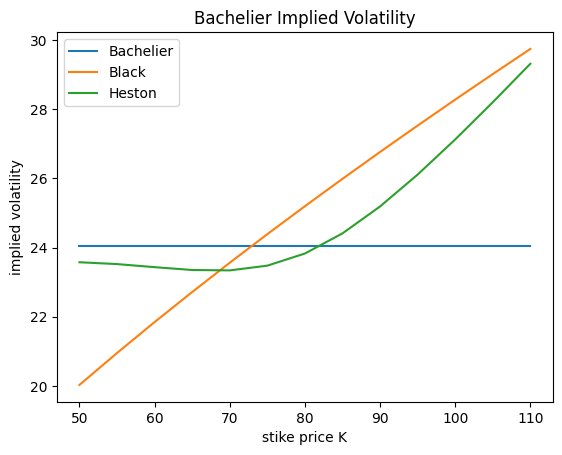

In [16]:
# Bachelier implied volatility
list_iv_bachelier, list_iv_black, list_iv_heston = [], [], []
for bachelier_, black_, heston_, stirke_ in zip(arr_bachelier_call, arr_black_call, list_heston_call, arr_strike):
  list_iv_bachelier.append(implied_volatility(bachelier_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'bachelier', method='brent', disp=True))
  list_iv_black.append(implied_volatility(black_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'bachelier', method='brent', disp=True))
  list_iv_heston.append(implied_volatility(heston_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'bachelier', method='brent', disp=True))


plt.plot(arr_strike, list_iv_bachelier, label = 'Bachelier')
plt.plot(arr_strike, list_iv_black, label = 'Black')
plt.plot(arr_strike, list_iv_heston, label = 'Heston')
plt.title('Bachelier Implied Volatility')
plt.xlabel('stike price K')
plt.ylabel('implied volatility')
plt.legend()
plt.show()

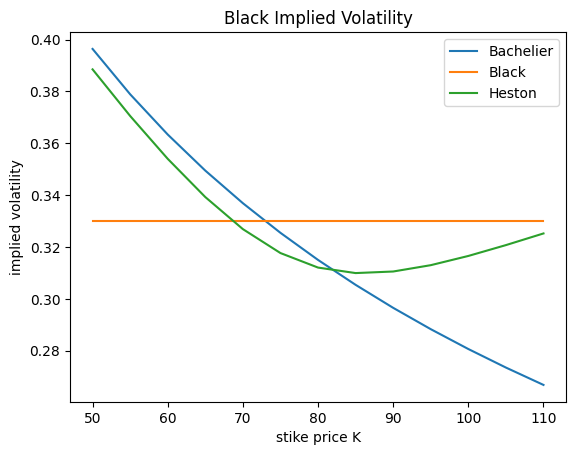

In [17]:
# Black implied volatility
list_iv_bachelier, list_iv_black, list_iv_heston = [], [], []
for bachelier_, black_, heston_, stirke_ in zip(arr_bachelier_call, arr_black_call, list_heston_call, arr_strike):
  list_iv_bachelier.append(implied_volatility(bachelier_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'black', method='brent', disp=True))
  list_iv_black.append(implied_volatility(black_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'black', method='brent', disp=True))
  list_iv_heston.append(implied_volatility(heston_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'black', method='brent', disp=True))


plt.plot(arr_strike, list_iv_bachelier, label = 'Bachelier')
plt.plot(arr_strike, list_iv_black, label = 'Black')
plt.plot(arr_strike, list_iv_heston, label = 'Heston')
plt.title('Black Implied Volatility')
plt.xlabel('stike price K')
plt.ylabel('implied volatility')
plt.legend()
plt.show()

In [18]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Read CSV file from Google Drive
filename = '/content/gdrive/MyDrive/job preparation/data/' +\
              'clu23-options-american-options-exp-08_17_23-20-strikes-+_--side-by-side-%futuresoptionstime%-07-07-2023.csv'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
df_raw_data = pd.read_csv(filename, header=0, index_col = 5)
df_raw_data = df_raw_data.iloc[:-1]
df_raw_data.head()

,Type,Last,Volume,Open Int,Premium,Type.1,Last.1,Volume.1,Open Int.1,Premium.1
Strike,,,,,,,,,,
63.0,Call,9.42s,NaN,455,"9,420.00",Put,0.56,60.0,"3,324",560.00
63.5,Call,8.99s,NaN,208,"8,990.00",Put,0.61,99.0,625,610.00
64.0,Call,8.57s,2,25,"8,570.00",Put,0.69,20.0,"1,313",690.00
64.5,Call,8.97,1,13,"8,970.00",Put,0.83,20.0,331,830.00
65.0,Call,8.75,5,306,"8,750.00",Put,0.85,194.0,"11,955",850.00


In [20]:
list_data = []
for index_ in df_raw_data.index:
  if index_ < futures_price:
    if not 's' in str(df_raw_data.loc[index_, 'Last.1']):
      list_data.append((index_, float(df_raw_data.loc[index_, 'Last.1']), 'put'))
  else:
    if not 's' in str(df_raw_data.loc[index_, 'Last']):
      list_data.append((index_, float(df_raw_data.loc[index_, 'Last']), 'call'))

arr_data = np.array(list_data)
df_data = pd.DataFrame({'price': arr_data.T[1].astype(float), 'option type': arr_data.T[2]}, index = arr_data.T[0].astype(float))
df_data

,price,option type
63.0,0.56,put
63.5,0.61,put
64.0,0.69,put
64.5,0.83,put
65.0,0.85,put
65.5,0.91,put
66.0,1.05,put
66.5,1.10,put
67.0,1.24,put
67.5,1.37,put


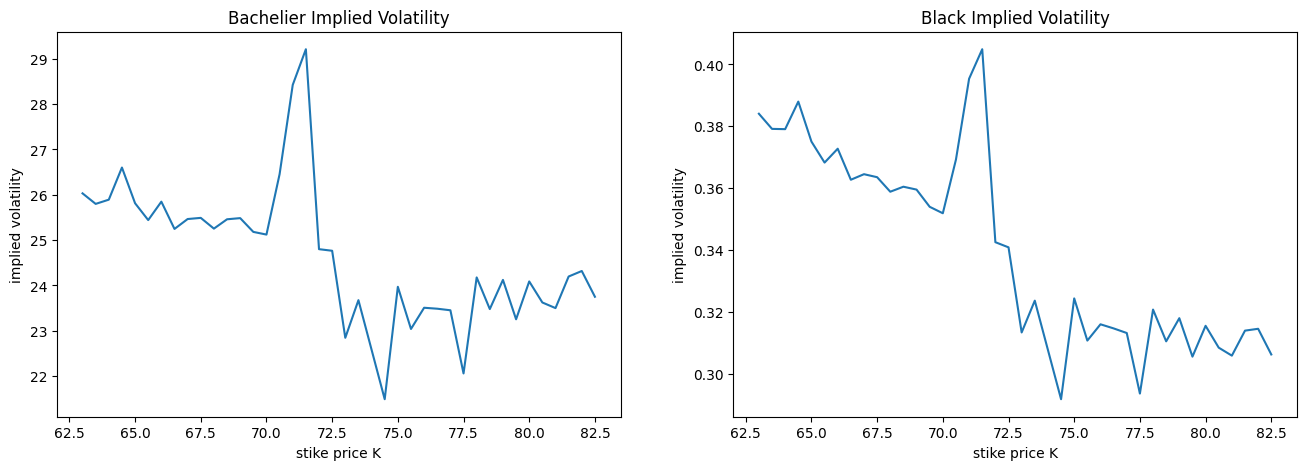

In [21]:
# Bachelier and Black implied volatility
list_mkt_iv_bachelier, list_mkt_iv_black = [], []
for strike_, price_, option_type_ in zip(df_data.index, df_data.loc[:,'price'], df_data.loc[:,'option type']):
  list_mkt_iv_bachelier.append(implied_volatility(price_, futures_price, strike_, risk_free_rate, time_to_maturity,
                                                          option_type = option_type_, model = 'bachelier', method='brent', disp=False))
  list_mkt_iv_black.append(implied_volatility(price_, futures_price, strike_, risk_free_rate, time_to_maturity,
                                                          option_type = option_type_, model = 'black', method='brent', disp=False))

fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(121)
ax1.plot(df_data.index, list_mkt_iv_bachelier)
ax1.set_title('Bachelier Implied Volatility')
ax1.set_xlabel('stike price K')
ax1.set_ylabel('implied volatility')

ax2 = fig.add_subplot(122)
ax2.plot(df_data.index, list_mkt_iv_black)
ax2.set_title('Black Implied Volatility')
ax2.set_xlabel('stike price K')
ax2.set_ylabel('implied volatility')

plt.show()